# Libraries and Data Import
Also have a quick look at the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
#sns.set(rc={'figure.facecolor': "white"})
plt.style.use('seaborn')
repository_directory = "../"
PlotMeanAndMedian = False

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
#import graphviz
#from dtreeviz.trees import dtreeviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance


import os
import sys
# add .. to path so python can find our script in ../src/data/
sys.path.append("..")
from src.data.preprocessing import load_preprocess_data
from src.features.feature_engineering import create_features, unwrap_smart_7


# Data Import

In [3]:
repo_path = os.getcwd() + "/../"
df_source = load_preprocess_data(path=repo_path)
df = create_features(df_source, interval=30, trigger_percentage=0.05)
df = unwrap_smart_7(df)
df = df.drop("smart_7_raw", axis=1)
cols = df.columns.to_list()
cols[cols.index("smart_999")] = cols[cols.index("smart_999")].replace("smart_999", "smart_999_raw")
cols[cols.index("smart_7_mod")] = cols[cols.index("smart_7_mod")].replace("smart_7_mod", "smart_7_raw")
df.columns = pd.Index(cols)
#df = df_source.copy()

  0%|          | 0/608 [00:00<?, ?it/s]../src/features/feature_engineering.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.smart_7_mod[temp_data.index] = temp_data.smart_7_raw
100%|██████████| 608/608 [00:12<00:00, 47.13it/s]


In [4]:
# df_source[df_source.isna().any(axis=1)]
df_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462966 entries, 0 to 463088
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  462966 non-null  datetime64[ns]
 1   serial_number         462966 non-null  object        
 2   model                 462966 non-null  object        
 3   failure               462966 non-null  int64         
 4   smart_1_normalized    462966 non-null  float64       
 5   smart_1_raw           462966 non-null  float64       
 6   smart_3_normalized    462966 non-null  float64       
 7   smart_4_raw           462966 non-null  float64       
 8   smart_5_normalized    462966 non-null  float64       
 9   smart_5_raw           462966 non-null  float64       
 10  smart_7_normalized    462966 non-null  float64       
 11  smart_7_raw           462966 non-null  float64       
 12  smart_9_normalized    462966 non-null  float64       
 13 

Check for duplicates:

In [5]:
serials_failed = df_source.query("failure == 1")["serial_number"].to_list()
serials_failed_unique = set(serials_failed)
print("Number of failed days:", len(serials_failed))
print("Number of unique serial number on the failed day:", len(serials_failed_unique))
tmp = serials_failed[:]
for serial in serials_failed_unique:
    tmp.remove(serial)

if len(tmp) == 0:
    print("There is no duplicate")
else:
    print(f"There {len(tmp)} duplicates")
    print("   duplicated serial numbers",tmp)
    df.drop(298155, inplace=True)
    df.drop(309081, inplace=True)
    df.reset_index(inplace=True)
    print("Number of rows before drop:", len(df_source))
    print("Number of rows after drop:", len(df))   

Number of failed days: 610
Number of unique serial number on the failed day: 608
There 2 duplicates
   duplicated serial numbers ['Z302SQFX', 'Z303VDR4']
Number of rows before drop: 462966
Number of rows after drop: 462964


Show one of the duplicates:

In [6]:
df_source.query("serial_number == @tmp[0]").sort_values(by="date", ascending=False).head(6)

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown
298155,2021-10-11,Z302SQFX,ST4000DM000,1,111.0,32839264.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53663.0,6.820128e+10,2.930498e+11,2021-10-11,0
298238,2021-10-11,Z302SQFX,ST4000DM000,1,111.0,32839264.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53663.0,6.820128e+10,2.930498e+11,2021-10-11,0
298066,2021-10-10,Z302SQFX,ST4000DM000,0,119.0,234015344.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53639.0,6.818406e+10,2.929217e+11,2021-10-11,1
297974,2021-10-09,Z302SQFX,ST4000DM000,0,111.0,36343000.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53615.0,6.816239e+10,2.928034e+11,2021-10-11,2
297884,2021-10-08,Z302SQFX,ST4000DM000,0,112.0,48097320.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53590.0,6.814426e+10,2.927009e+11,2021-10-11,3
297788,2021-10-07,Z302SQFX,ST4000DM000,0,119.0,213927912.0,92.0,9.0,100.0,184.0,...,99.0,248.0,99.0,248.0,0.0,53565.0,6.812408e+10,2.925268e+11,2021-10-11,4


Set up the classification column (1 for failure in 30 days and 0 for failure beyond 30 days):

In [7]:
days_before_failure = 30
def get_classification(countdown, days=days_before_failure):
    if countdown <= days:
        return 1
    return 0

df["failure_in_30_days"] = df["countdown"].apply(get_classification)
df.head(3)

,index,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_9_raw,smart_12_raw,...,smart_187_raw_trigger,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999_raw,failure_in_30_days
0,0,2020-09-18,Z304JG86,ST4000DM000,0,93783288.0,13.0,0.0,42390.0,13.0,...,False,False,False,False,False,False,False,False,0,0
1,1,2020-09-18,S301GMGZ,ST4000DM000,0,55185864.0,13.0,0.0,42857.0,13.0,...,True,False,False,False,False,True,True,False,3,0
2,2,2020-09-18,S300YQTN,ST4000DM000,0,170426904.0,6.0,0.0,46828.0,6.0,...,False,False,False,False,False,False,False,False,0,0


# Some useful functions and lists

In [8]:
# specify commonly used column names
column_name_all = list(df.columns)
column_name_basic = column_name_all[:4] + column_name_all[-3:]
column_name_smart_all = [c for c in column_name_all if "smart_" in c ]
column_name_smart_raw = [c for c in column_name_smart_all if "_raw" in c ]
column_name_smart_normalized = [c for c in column_name_smart_all if "normalized" in c ]
#column_name_smart_raw = pd.Index([c for c in column_name_smart if "raw" in c ])
#column_name_smart_normalized = pd.Index([c for c in column_name_smart if "normalized" in c ])

# collections of important smart parameters from different sources
key_smart_backblaze = [5, 187, 188, 197, 198] # https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/
key_smart_wiki = [5, 10, 184, 187, 188, 196, 197, 198, 201] # https://en.wikipedia.org/wiki/S.M.A.R.T.
key_smart_ai_paper = [3, 5, 7, 187, 188, 190, 197, 198] # https://www.sciencedirect.com/science/article/pii/S2666827021000219
key_smart_preprocessed = [1, 4, 5, 7, 9, 12, 183, 184, 187, 188, 189, 190, 192, 193, 194, 197, 198, 199, 240, 241, 242]
key_smart_check = [4, 5, 7, 9, 12, 183, 184, 187, 188, 189, 192, 193, 197, 198, 240, 241, 242, 999]
key_smart_baseline = [5, 183, 184, 187]

def smart2meaningful(col):
    """smart to meaningful names
    see wiki for more info: https://en.wikipedia.org/wiki/S.M.A.R.T.

    Args:
        col (panda.Index): name of columns returned from a dataframe

    Returns:
        panda.Index: a column with more meaningful names
    """
    dict_smart = {1   : 'read_error_rate', # vecdor-dependent
                  #3   : "spin_up_time",
                  4   : 'start_stop_count',
                  5   : "reallocated_sector_count", # or "bad-sector count" 
                  7   : "seek_error_rate", # or "reading-head seek-error rate", vendor-dependent
                  9   : "power_on_time", 
                  #10  : "spin_retry_count",
                  12  : 'power_cycle_count',
                  183 : "downshift_error_count", #  another possible meaning is: Runtime Bad Block
                  184 : "end_to_end_error", # vendor-dependent
                  187 : "reported_uncorrectable_error",
                  188 : "command_timeout_count",
                  189 : 'high_fly_write_count',
                  190 : "temperature_special", # vendor-dependent
                  192 : 'emergency_retract_count',
                  193 : 'load_cycle_count',
                  194 : "temperature",
                  #196 : "reallocation_event_count",
                  197 : "current_pending_sector_count", # or "unusable sector count"
                  198 : "uncorrectable_sector_count", 
                  199 : 'cable_data_transfer_error',
                  #201 : "software_read_error_count", 
                  #231 : "expected_life_left",
                  240 : 'head_flying_time',
                  241 : 'total_lba_written', # lba = logical block addressing (blocks where data is stored)
                  242 : 'total_lba_read'
    }
    if col == None:
        for key, value in dict_smart.items():
            print(f'Smart {key}: {value}')
        return
    col_modified = []
    for name in list(col):
        if "smart_" in name:
            number = int(name.split("smart_")[1].split("_")[0])
            if number in list(dict_smart.keys()):
                col_modified.append(name.replace("smart_" + str(number), dict_smart[number]))
            else:
                col_modified.append(name)
        else:
            col_modified.append(name)
    return pd.Index(col_modified)

# change the smart name into meaningful names for a dataframe
# this should be applied only after you perform all operations on columns
def smart2meaningful_for_dataframe(df):
    df.columns = smart2meaningful(df.columns)
    return df

# drop all smart columns except those specified by smart_to_keep
def keep_some_smart_column_for_dataframe(df, smart_to_keep=[], raw_or_normalized="raw"):
    cols = df.columns
    cols_nonsmart = [col for col in cols if not "smart_" in col]
    #cols_smart = [col for col in cols if "smart_" in col]
    #s = set(cols_smart)
    cols_smart = ["smart_" + str(i) + "_" + raw_or_normalized for i in smart_to_keep]
    #cols_smart.remove('smart_999_raw')
    #cols_smart.append('smart_999')
    return df[cols_nonsmart + cols_smart]

def change_feature_dtype_for_dataframe(df, feature_to_change=[]):
    col = df.columns
    for feature in feature_to_change:
        if not feature in col:
            print("### Error!")
            print(f"### The feature '{feature}' is not found in the dataframe '{df}'!")
            print("### Partially modified dataframe is returned!")
            return df
        if feature == "failure":
            df.astype({feature : "int64"})
        elif feature == "date":
            df[feature] = pd.to_datetime(df[feature], format='%Y-%m-%d')
    return df

# create features for a dataframe
def create_features_for_dataframe(df, features_to_create=[], drop=False):
    feature_to_drop = []
    col = df.columns
    for feature in features_to_create:
        if feature == "capacity_gb":
            features_needed = ["capacity_bytes"]
            for feature_needed in features_needed:
                if not feature_needed in col:
                    print("### Error!")
                    print(f"### Cannot create '{feature}' because the required feature '{feature_needed}' is not found in the dataframe '{df}'!")
                    print("### Partially modified dataframe is returned!")
                    return df
            gb2byte = 1024**3
            df[feature] = df[features_needed[0]].apply(lambda x : int(x)/gb2byte)
            feature_to_drop.append(*features_needed)
        #elif feature == "power_on_time_day":
        #    df[feature] = df["power_on_time"].apply(lambda x : x/24)
        #    feature_to_drop.append("power_on_time")
    if drop:
        df.drop(list(set(feature_to_drop)), axis=1, inplace=True)
    return df

# Keep only Clean Features

In [9]:
# choose smart and set up the column name 
#key_smart = [5, 183, 184, 187]
#key_smart = [1, 4, 5, 7, 9, 12, 183, 184, 187, 188, 189, 190, 192, 193, 194, 197, 198, 199, 240, 241, 242]
key_smart = key_smart_check

column_name_smart = ["smart_" + str(i) + "_" + "raw" for i in key_smart]
#column_name = column_name_basic + column_name_smart
column_name = column_name_basic + column_name_smart_raw
print("Columns chosen for the dataframe:\n", column_name)

df = keep_some_smart_column_for_dataframe(df, smart_to_keep=key_smart, raw_or_normalized="raw")
df.head(3)

Columns chosen for the dataframe:
 ['index', 'date', 'serial_number', 'model', 'smart_199_raw_trigger', 'smart_999_raw', 'failure_in_30_days', 'smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_9_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'smart_7_raw', 'smart_1_raw_ema', 'smart_4_raw_ema', 'smart_5_raw_ema', 'smart_7_raw_ema', 'smart_9_raw_ema', 'smart_12_raw_ema', 'smart_183_raw_ema', 'smart_184_raw_ema', 'smart_187_raw_ema', 'smart_188_raw_ema', 'smart_189_raw_ema', 'smart_190_raw_ema', 'smart_192_raw_ema', 'smart_193_raw_ema', 'smart_194_raw_ema', 'smart_197_raw_ema', 'smart_198_raw_ema', 'smart_199_raw_ema', 'smart_240_raw_ema', 'smart_241_raw_ema', 'smart_242_raw_ema', 'smart_4_raw_trigger', 'smart_5_raw_trigger', 'smart_12_raw_trigger', 'smart_183_

,index,date,serial_number,model,failure,date_failure,countdown,failure_in_30_days,smart_4_raw,smart_5_raw,...,smart_188_raw,smart_189_raw,smart_192_raw,smart_193_raw,smart_197_raw,smart_198_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_999_raw
0,0,2020-09-18,Z304JG86,ST4000DM000,0,2020-11-07,50,0,13.0,0.0,...,0.0,0.0,0.0,6846.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,0
1,1,2020-09-18,S301GMGZ,ST4000DM000,0,2021-05-31,255,0,13.0,0.0,...,0.0,0.0,0.0,10166.0,16.0,16.0,42778.0,5.982921e+10,2.557590e+11,3
2,2,2020-09-18,S300YQTN,ST4000DM000,0,2021-05-28,252,0,6.0,0.0,...,0.0,0.0,0.0,38881.0,16.0,16.0,46671.0,6.363719e+10,2.580255e+11,0


## Train-Test Split

We will split the data according to serial numbers

In [10]:
RSEED = 200
serial_number_train, serial_number_test, dummy_train, dummy_test = train_test_split(df["serial_number"].unique(), df["serial_number"].unique(), test_size=0.2, random_state=RSEED)
serial_number_train = pd.Series(serial_number_train)
serial_number_test = pd.Series(serial_number_test)

df_train = df[ df["serial_number"].isin(serial_number_train)]
df_train = df_train.drop("index", axis=1).reset_index(drop=True)
y_train = df_train["failure_in_30_days"]
X_train = df_train[column_name_smart]

df_test = df[ df["serial_number"].isin(serial_number_test)]
df_test = df_test.drop("index", axis=1).reset_index(drop=True)
y_test = df_test["failure_in_30_days"]
X_test = df_test[column_name_smart]

print("number of unique disk in data:", df["serial_number"].nunique())
print("number of unique disk in train:", df_train["serial_number"].nunique())
print("number of unique disk in test:", df_test["serial_number"].nunique())

failed_days = df_train.query("failure == 1")["failure"].count()
healthy_days = df_train.query("failure == 0")["failure"].count()
print("number of days for failed/healthy drive in train:", failed_days, "/", healthy_days, '=', (failed_days/healthy_days*100).round(4),"%")
failed_days = df_test.query("failure == 1")["failure"].count()
healthy_days = df_test.query("failure == 0")["failure"].count()
print("number of days for failed/healthy drive in test:", failed_days, "/", healthy_days, '=', (failed_days/healthy_days*100).round(4),'%')

failed_days = df_train.query("failure_in_30_days == 1")["failure"].count()
healthy_days = df_train.query("failure_in_30_days == 0")["failure"].count()
print("number of days for fail-in-30 / not-fail-in-30 in train:", failed_days, "/", healthy_days, '=', (failed_days/healthy_days*100).round(4),"%")
failed_days = df_test.query("failure_in_30_days == 1")["failure"].count()
healthy_days = df_test.query("failure_in_30_days == 0")["failure"].count()
print("number of days for fail-in-30 / not-fail-in-30 in test:", failed_days, "/", healthy_days, '=', (failed_days/healthy_days*100).round(4),'%')

number of unique disk in data: 608
number of unique disk in train: 486
number of unique disk in test: 122
number of days for failed/healthy drive in train: 486 / 373101 = 0.1303 %
number of days for failed/healthy drive in test: 122 / 89255 = 0.1367 %
number of days for fail-in-30 / not-fail-in-30 in train: 15071 / 358516 = 4.2037 %
number of days for fail-in-30 / not-fail-in-30 in test: 3772 / 85605 = 4.4063 %


In [11]:
df_train.head(3)

,date,serial_number,model,failure,date_failure,countdown,failure_in_30_days,smart_4_raw,smart_5_raw,smart_7_raw,...,smart_188_raw,smart_189_raw,smart_192_raw,smart_193_raw,smart_197_raw,smart_198_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_999_raw
0,2020-09-18,Z304JG86,ST4000DM000,0,2020-11-07,50,0,13.0,0.0,1.208037e+09,...,0.0,0.0,0.0,6846.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,0
1,2020-09-18,S300YQTN,ST4000DM000,0,2021-05-28,252,0,6.0,0.0,1.638586e+09,...,0.0,0.0,0.0,38881.0,16.0,16.0,46671.0,6.363719e+10,2.580255e+11,0
2,2020-09-18,Z302T8AB,ST4000DM000,0,2020-12-04,77,0,27.0,0.0,1.615135e+09,...,0.0,0.0,2.0,12051.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11,0


Plot smart states vs countdown, using mean:

In [12]:
if PlotMeanAndMedian:
    fig, axes = plt.subplots(2,2,figsize=(20, 10))
    #fig.suptitle("Smart vs Mean")

    j = 0
    for i, col in enumerate([name for name in df_train.columns if "smart" in name and "raw" in name]):
        number = col.split("smart_")[1].split("_")[0]
        if int(number) in [5, 183, 184, 187]:
            sns.lineplot(data=df_train, x="countdown", y=col, estimator="mean", ax=axes[j//2,j%2])
            #axes[j].set_title(f"smart {number} - Mean")
            #axes[j//2,j%2].set_ylabel(f"Smart {number} raw", fontsize=30)
            if int(number) == 5:
                y_name = "Reallocate Sectors"
            elif int(number) == 183:
                y_name = "Runtime Bad Blocks"
            elif int(number) == 184:
                y_name = 'End-to-end Errors'
            elif int(number) == 187:
                y_name = 'Uncorrectable Errors'
            axes[j//2,j%2].set_ylabel(y_name, fontsize=35)
            axes[j//2,j%2].set_yticklabels(axes[j//2,j%2].get_yticks(), size=25)
                           #set_yticklabels
            axes[j//2,j%2].set_xlabel(f"Countdown", fontsize=35)
            axes[j//2,j%2].set_xticklabels(axes[j//2,j%2].get_xticks(), size=25)
            j += 1
    
    fig.tight_layout()
    plt.show()
    fig.savefig("mean.png")


Plot smart states vs countdown, using medain:

In [13]:
if PlotMeanAndMedian:
    fig, axes = plt.subplots(2,2,figsize=(20, 10))
    #fig.suptitle("Smart vs Median")

    j = 0
    for i, col in enumerate([name for name in df_train.columns if "smart" in name]):
        number = col.split("smart_")[1].split("_")[0]
        if int(number) in [5, 183, 184, 187]:
            sns.lineplot(data=df_train, x="countdown", y=col, estimator=np.median, ax=axes[j//2,j%2])
            #axes[j].set_title(f"smart {number} - Mean")
            axes[j//2,j%2].set_ylabel(f"Smart {number} raw", fontsize=30)
            axes[j//2,j%2].set_xlabel(f"Countdown", fontsize=20)
            j += 1
            
    fig.tight_layout()
    plt.show()

Initiate the dictionary to store scores/metrics for various models:

In [14]:
performance = dict()

Define the function for showing results of a model:

In [15]:
def evaluate_metrics(model_name, y_train, y_train_pred, y_test, y_test_pred, model=None, X_train=None, X_test=None):

    performance[model_name] = dict()

    for data in ["train", "test"]:
        print("=======================================")
        print(f"# For {data} data:")
        if data == "train":
            y_true = y_train
            y_pred = y_train_pred
        else:
            y_true = y_test
            y_pred = y_test_pred
        f2 = fbeta_score(y_true, y_pred, beta=2)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        print("  f2-score  :", (f2*100).round(20), "%")
        print("  precision :", (pre*100).round(20), "%")
        print("  recall    :", (rec*100).round(20), "%")
        print("  accuracy  :", (acc*100).round(20), "%")
        #print("Data | f2 | precision | recall | accuracy")
        #print("Train")
        #print("Test")

    performance[model_name]["f2"] = f2
    performance[model_name]["precision"] = pre
    performance[model_name]["recall"] = rec
    performance[model_name]["accuracy"] = acc


    fig, axes = plt.subplots(2,2,figsize=(6, 6))
    fig.suptitle("Confusion Matrix")
    for i in range(4):
        if i//2 == 0:
            train_or_test = "Train"
            y_true = y_train
            y_pred = y_train_pred
        else:
            train_or_test = "Test"
            y_true = y_test
            y_pred = y_test_pred
        if i%2 == 0:
            scale = " (log scale)"
            data = np.log10(confusion_matrix(y_true, y_pred))
        else:
            data = confusion_matrix(y_true, y_pred)
            scale = ""
        sns.heatmap(data, annot=True, ax=axes[i//2, i%2])
        axes[i//2,i%2].set_title(f"{train_or_test}{scale}")
        axes[i//2,i%2].set_ylabel("Truth", fontsize=25)
        axes[i//2,i%2].set_xlabel("Prediction", fontsize=25)

    fig.tight_layout()
    plt.show()

    performance[model_name]["confusion_matrix"] = confusion_matrix(y_test, y_test_pred)

    if not model == None:
        print("=======================================")
        print("           ROC - Train Data            ")
        #roc_auc_score(y, model.predict_proba(X)[:, 1])
        RocCurveDisplay.from_estimator(model, X_train, y_train)
        print("=======================================")
        print("           ROC - Test Data            ")
        RocCurveDisplay.from_estimator(model, X_test, y_test)
    

# Data Scaling

We could observe the data and decide how to scale the data:

In [16]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
smart_4_raw,373587.0,1.198715e+01,8.261919e+00,1.000000e+00,7.000000e+00,1.000000e+01,1.400000e+01,1.660000e+02
smart_5_raw,373587.0,9.393018e+01,1.286075e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.548800e+04
smart_7_raw,373587.0,1.675401e+10,4.395963e+11,6.918540e+05,6.623637e+08,1.016802e+09,1.453142e+09,1.689320e+13
smart_9_raw,373587.0,3.769428e+04,6.847131e+03,1.210300e+04,3.241400e+04,3.719600e+04,4.265850e+04,5.744800e+04
smart_12_raw,373587.0,1.182052e+01,8.584923e+00,1.000000e+00,7.000000e+00,1.000000e+01,1.400000e+01,1.650000e+02
smart_183_raw,373587.0,4.055725e+00,3.009603e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,7.200000e+02
smart_184_raw,373587.0,1.691895e-01,4.380564e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.400000e+02
smart_187_raw,373587.0,4.983632e+00,2.167630e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.960000e+02
smart_188_raw,373587.0,4.154320e-02,6.284110e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.700000e+01
smart_189_raw,373587.0,3.597556e-03,2.594473e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01


It looks like a log transformation would be nice for all of the smart features.

In [17]:
#cols = X_train.columns
#cols_smart = [c for c in cols if "smart_" in c ]
#cols_nonsmart = [c for c in cols if not "smart_" in c ]
X_train_log = X_train.apply(lambda x : np.log10(x+1))
#X_train_log = pd.concat([X_train[cols_nonsmart], X_train_log], axis=1)
X_test_log = X_test.apply(lambda x : np.log10(x+1))
#X_test_log = pd.concat([X_test[cols_nonsmart], X_test_log], axis=1)

Now we can have a look at the distribution again at the transformed data

In [18]:
X_train_log.describe()

,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_192_raw,smart_193_raw,smart_197_raw,smart_198_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_999_raw
count,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000
mean,1.056129,0.108280,8.997465,4.568893,1.047972,0.225670,0.006324,0.241463,0.006341,0.000249,0.088929,4.083618,0.190631,0.190631,4.566694,10.726351,11.293914,0.062541
std,0.216614,0.526352,0.317782,0.081192,0.220382,0.410721,0.093532,0.492106,0.065585,0.017954,0.192561,0.422753,0.522118,0.522118,0.081476,0.077494,0.152797,0.172667
min,0.301030,0.000000,5.840015,4.082929,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.283301,0.000000,0.000000,4.082785,10.114767,10.835240,0.000000
25%,0.903090,0.000000,8.821097,4.510746,0.903090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.896030,0.000000,0.000000,4.508220,10.698584,11.171997,0.000000
50%,1.041393,0.000000,9.007236,4.570508,1.041393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.054077,0.000000,0.000000,4.568213,10.739488,11.285831,0.000000
75%,1.176091,0.000000,9.162308,4.630016,1.176091,0.477121,0.000000,0.000000,0.000000,0.000000,0.000000,4.196397,0.000000,0.000000,4.628072,10.774117,11.398950,0.000000
max,2.222716,4.816168,13.227712,4.759282,2.220108,2.857935,2.532754,2.775974,1.579784,1.301030,2.071882,5.375905,4.815000,4.815000,4.757821,10.874534,11.964377,1.000000


Perform scaling with MinMaxScaler so the range is between 0 and 1:

In [19]:
scaler = MinMaxScaler()

X_train_log_scaled = pd.DataFrame(scaler.fit_transform(X_train_log), columns=X_train_log.columns)
#X_train_log_scaled = pd.concat([X_train_log[cols_nonsmart], X_train_log_scaled], axis=1)

X_test_log_scaled = pd.DataFrame(scaler.transform(X_test_log), columns=X_test_log.columns)
#X_test_log_scaled = pd.concat([X_test_log[cols_nonsmart], X_test_log_scaled], axis=1)


In [20]:
X_train_log_scaled.describe()

,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_192_raw,smart_193_raw,smart_197_raw,smart_198_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_999_raw
count,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000
mean,0.392936,0.022483,0.427393,0.718505,0.389219,0.078963,0.002497,0.086983,0.004014,0.000192,0.042922,0.582136,0.039591,0.039591,0.716863,0.804964,0.406216,0.062541
std,0.112721,0.109289,0.043015,0.120044,0.114837,0.143712,0.036929,0.177273,0.041515,0.013800,0.092940,0.136698,0.108436,0.108436,0.120699,0.101998,0.135322,0.172667
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.313298,0.000000,0.403520,0.632535,0.313724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521479,0.000000,0.000000,0.630240,0.768417,0.298243,0.000000
50%,0.385267,0.000000,0.428716,0.720894,0.385791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.572584,0.000000,0.000000,0.719115,0.822254,0.399058,0.000000
75%,0.455361,0.000000,0.449706,0.808877,0.455980,0.166946,0.000000,0.000000,0.000000,0.000000,0.000000,0.618604,0.000000,0.000000,0.807789,0.867832,0.499240,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Baseline Model

Median for smart 5 raw: 0.0
Median for smart 183 raw: 0.0
Median for smart 184 raw: 0.0
Median for smart 187 raw: 0.0
# For train data:
  f2-score  : 29.969560297703477 %
  precision : 11.535040637938966 %
  recall    : 49.91042399309933 %
  accuracy  : 82.53766860195884 %
# For test data:
  f2-score  : 28.36851449990136 %
  precision : 14.019693867602614 %
  recall    : 38.12301166489926 %
  accuracy  : 87.52139812255949 %


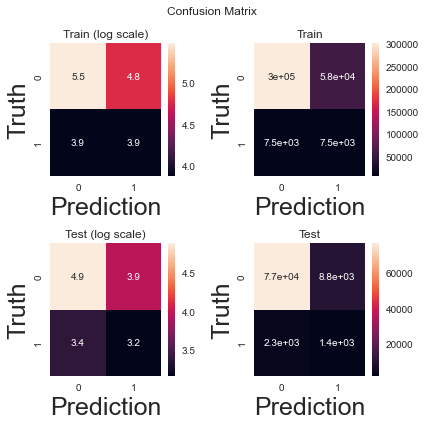

In [21]:
md5 = df_train["smart_5_raw"].median()
md183 = df_train["smart_183_raw"].median()
md184 = df_train["smart_184_raw"].median()
md187 = df_train["smart_187_raw"].median()
print("Median for smart 5 raw:", md5)
print("Median for smart 183 raw:", md183)
print("Median for smart 184 raw:", md184)
print("Median for smart 187 raw:", md187)

def baseline_failure_prediction(features, min_conditions=2):
    s5r = features["smart_5_raw"]
    s183r = features["smart_183_raw"]
    s184r = features["smart_184_raw"]
    s187r = features["smart_187_raw"]
    #if s5r >= 1.0 and s183r >= 5 and s184r >= 1 and s187r >= 20:
    if sum([s5r > md5, s183r > md183, s184r > md184, s187r > md187]) >= min_conditions:
        return 1
    return 0

y_train_pred = X_train.apply(baseline_failure_prediction, axis=1)
y_test_pred = X_test.apply(baseline_failure_prediction, axis=1)
evaluate_metrics("baseline", y_train, y_train_pred, y_test, y_test_pred)

# Feature Selection

In [22]:
# select features
#selection = [1, 4, 5, 7, 9, 12, 183, 184, 187, 188, 189, 190, 192, 193, 194, 197, 198, 199, 240, 241, 242]
#selection = [5, 9, 183, 184, 187]
selection = key_smart_check
selection_name = ["smart_" + str(i) + "_" + "raw" for i in selection]

X_train_tmp = X_train[selection_name]
X_test_tmp = X_test[selection_name]

X_train_log_tmp = X_train_log[selection_name]
X_test_log_tmp = X_test_log[selection_name]

X_train_log_scaled_tmp = X_train_log_scaled[selection_name]
X_test_log_scaled_tmp = X_test_log_scaled[selection_name]

# Logistic Regression (raw data)

# For train data:
  f2-score  : 0.7657093927018839 %
  precision : 20.945945945945947 %
  recall    : 0.6170791586490612 %
  accuracy  : 95.89680583103802 %
# For test data:
  f2-score  : 2.971435874496773 %
  precision : 16.577540106951872 %
  recall    : 2.4655355249204667 %
  accuracy  : 95.36010382984436 %


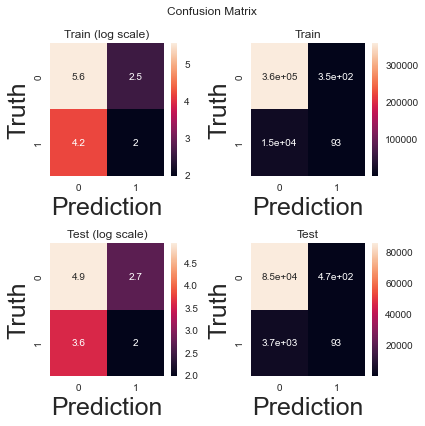

In [23]:
model_lr = LogisticRegression()
model_lr.fit(X_train_tmp, y_train)
y_train_pred = model_lr.predict(X_train_tmp)
y_test_pred = model_lr.predict(X_test_tmp)
evaluate_metrics("logistic_regression_raw", y_train, y_train_pred, y_test, y_test_pred)

# Logistic Regression (with log10)

/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# For train data:
  f2-score  : 7.836838791948478 %
  precision : 58.24835032993402 %
  recall    : 6.442837237077832 %
  accuracy  : 96.03947674838793 %
# For test data:
  f2-score  : 3.159197498697238 %
  precision : 36.74242424242424 %
  recall    : 2.5715800636267234 %
  accuracy  : 95.70135493471474 %


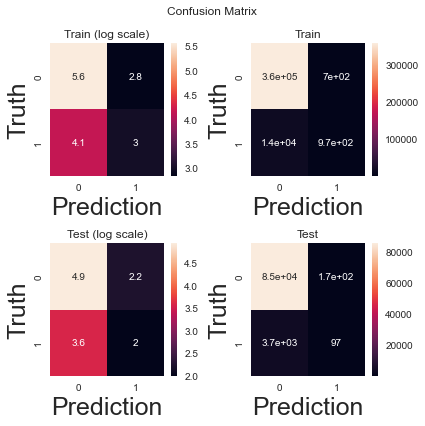

In [24]:
model_lr = LogisticRegression()
model_lr.fit(X_train_log_tmp, y_train)
y_train_pred = model_lr.predict(X_train_log_tmp)
y_test_pred = model_lr.predict(X_test_log_tmp)
evaluate_metrics("logistic_regression_log", y_train, y_train_pred, y_test, y_test_pred)

# Logistic Regression (with log10 and scaling)

/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# For train data:
  f2-score  : 8.779277682915042 %
  precision : 60.758082497212925 %
  recall    : 7.2324331497578145 %
  accuracy  : 96.06918870303303 %
# For test data:
  f2-score  : 4.112271540469974 %
  precision : 54.310344827586206 %
  recall    : 3.340402969247084 %
  accuracy  : 95.80205198205357 %


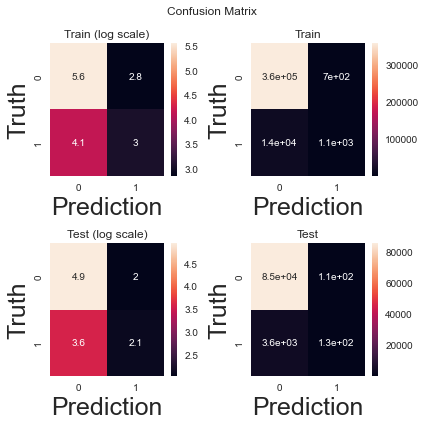

In [25]:
model_lr = LogisticRegression()
model_lr.fit(X_train_log_scaled_tmp, y_train)
y_train_pred = model_lr.predict(X_train_log_scaled_tmp)
y_test_pred = model_lr.predict(X_test_log_scaled_tmp)
evaluate_metrics("logistic_regression_log10_scaled", y_train, y_train_pred, y_test, y_test_pred)

# Decision Tree

# For train data:
  f2-score  : 91.65031960179884 %
  precision : 93.7418958575036 %
  recall    : 91.14192820648928 %
  accuracy  : 99.39719529855162 %
# For test data:
  f2-score  : 22.249966558166495 %
  precision : 13.598582913203431 %
  recall    : 26.458112407211026 %
  accuracy  : 89.80162681674257 %


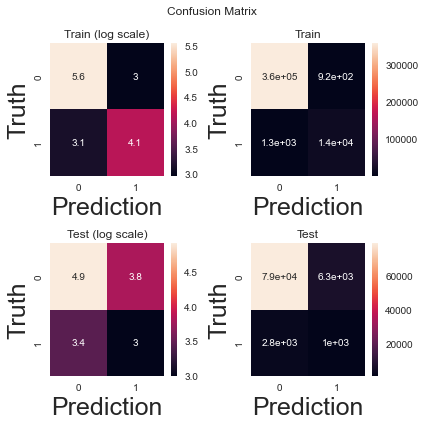

In [26]:
model_dt = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_leaf=20)
model_dt.fit(X_train_tmp, y_train)
y_train_pred = model_dt.predict(X_train_tmp)
y_test_pred = model_dt.predict(X_test_tmp)
evaluate_metrics("decision_tree", y_train, y_train_pred, y_test, y_test_pred)

[Text(0.5, 0.875, 'smart_9_raw <= 47851.5\ngini = 0.077\nsamples = 100.0%\nvalue = [0.96, 0.04]\nclass = y[0]'),
 Text(0.25, 0.625, 'smart_197_raw <= 36.0\ngini = 0.049\nsamples = 91.6%\nvalue = [0.975, 0.025]\nclass = y[0]'),
 Text(0.125, 0.375, 'smart_184_raw <= 9.5\ngini = 0.04\nsamples = 89.2%\nvalue = [0.979, 0.021]\nclass = y[0]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'smart_999_raw <= 0.5\ngini = 0.317\nsamples = 2.4%\nvalue = [0.802, 0.198]\nclass = y[0]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'smart_187_raw <= 78.5\ngini = 0.325\nsamples = 8.4%\nvalue = [0.796, 0.204]\nclass = y[0]'),
 Text(0.625, 0.375, 'smart_240_raw <= 51632.5\ngini = 0.292\nsamples = 7.8%\nvalue = [0.823, 0.177]\nclass = y[0]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'smart_12_raw <= 11.5\ngini = 0.5\nsamples = 0.7%\nvalue = [0.4

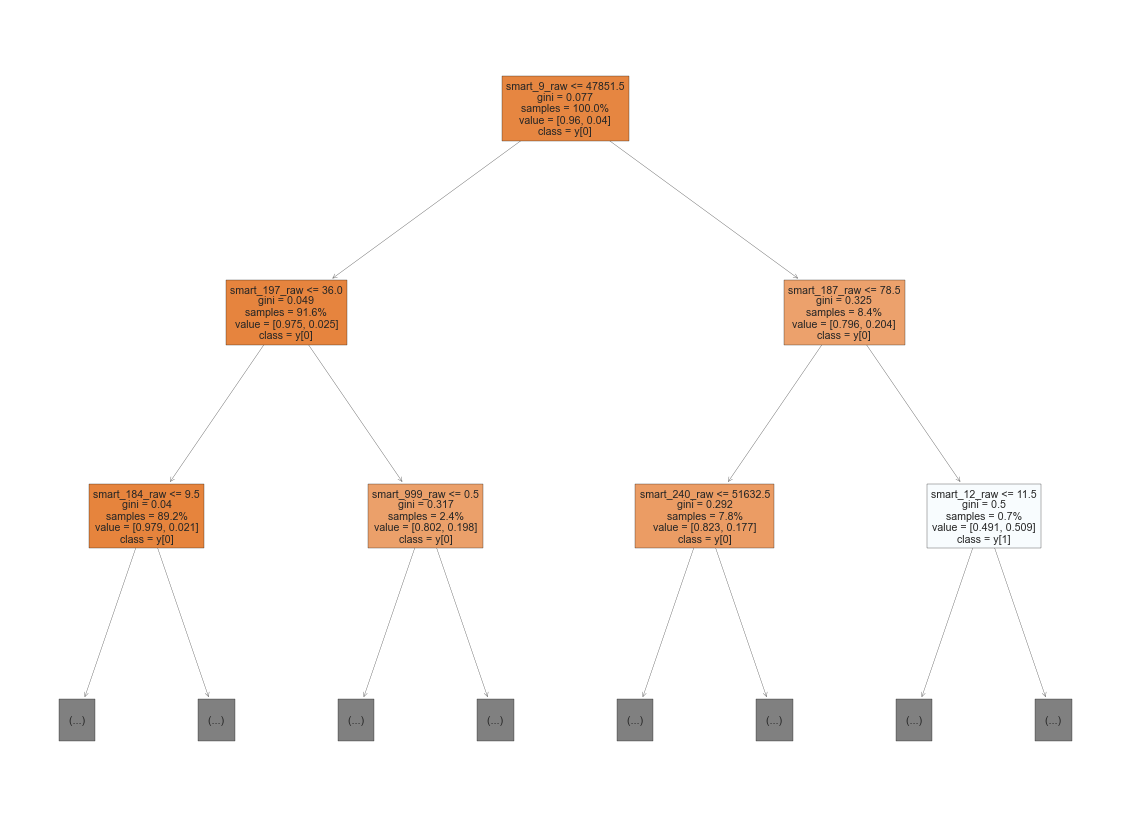

In [27]:
# plot tree structure
fig = plt.figure(figsize=(20,15))
plot_tree(model_dt, max_depth=2, feature_names=X_train.columns, class_names=True, filled=True, proportion=True)

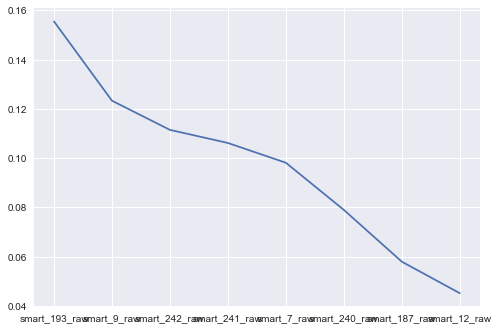

In [28]:
# plot importance
tmp = pd.Series(model_dt.feature_importances_, index=list(X_train_tmp.columns))
tmp = tmp.sort_values(ascending=False)
plt.plot(tmp[:8])

Grid search and cross validation:

# Random Forest

# For train data:
  f2-score  : 38.55491594264861 %
  precision : 96.98482811599767 %
  recall    : 33.50806184062106 %
  accuracy  : 97.27560113173102 %
# For test data:
  f2-score  : 14.07637115408002 %
  precision : 34.09425625920471 %
  recall    : 12.274655355249207 %
  accuracy  : 95.29632903319646 %


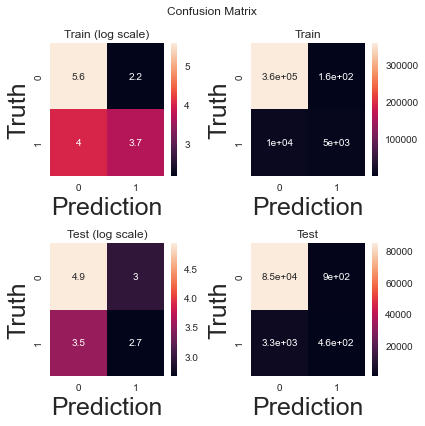

In [29]:
#model_rf = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", max_leaf_nodes=None, n_jobs=-1)
model_rf = RandomForestClassifier(n_estimators=10, criterion="gini", max_depth=10, min_samples_leaf=20, max_features="auto", max_leaf_nodes=None, n_jobs=-1, random_state=42)
model_rf.fit(X_train_tmp, y_train)
y_train_pred = model_rf.predict(X_train_tmp)
y_test_pred = model_rf.predict(X_test_tmp)
evaluate_metrics("random_forest", y_train, y_train_pred, y_test, y_test_pred)

# Gaussian Naive Bayes (raw data)

# For train data:
  f2-score  : 5.672560497254239 %
  precision : 12.533333333333333 %
  recall    : 4.989715347355849 %
  accuracy  : 94.76239804918265 %
# For test data:
  f2-score  : 4.644515898535191 %
  precision : 9.14419695193435 %
  recall    : 4.135737009544008 %
  accuracy  : 94.21998948275284 %


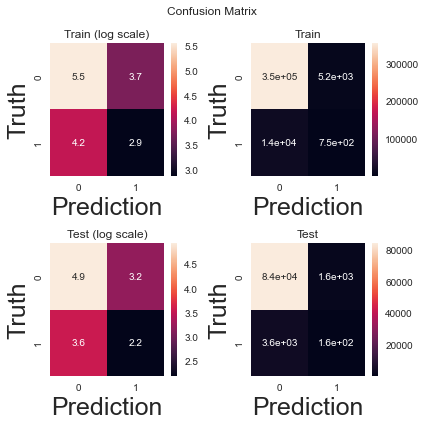

In [30]:
model_nbg = GaussianNB()
model_nbg.fit(X_train_tmp, y_train)
y_train_pred = model_nbg.predict(X_train_tmp)
y_test_pred = model_nbg.predict(X_test_tmp)
evaluate_metrics("gaussian_naive_bayes_raw", y_train, y_train_pred, y_test, y_test_pred)

# Gaussian Naive Bayes (log)

# For train data:
  f2-score  : 37.58266753316258 %
  precision : 17.73313492063492 %
  recall    : 52.18631809435338 %
  accuracy  : 88.30446455577952 %
# For test data:
  f2-score  : 34.948024948024944 %
  precision : 18.75697388975675 %
  recall    : 44.565217391304344 %
  accuracy  : 89.51408080378621 %


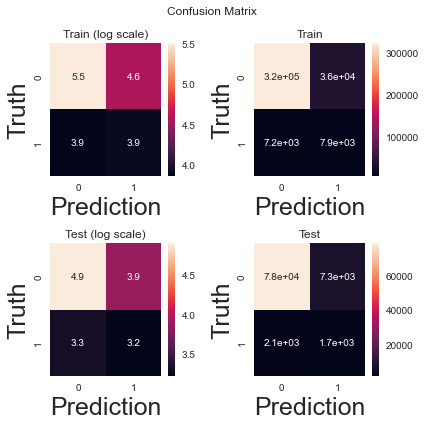

           ROC - Train Data            
           ROC - Test Data            


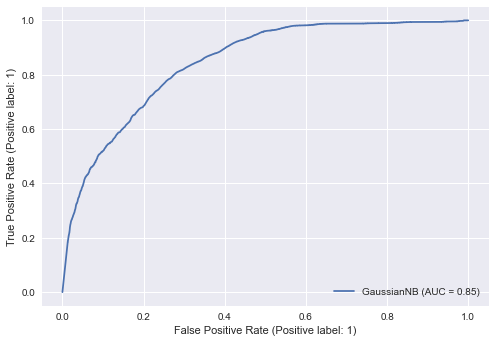

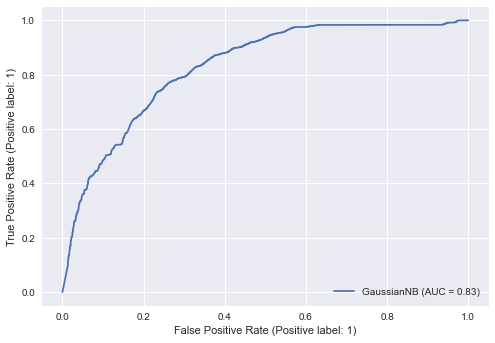

In [31]:
model = GaussianNB()
model.fit(X_train_log_tmp, y_train)
#y_train_pred = model.predict(X_train_log_tmp)
y_train_pred = model.predict(X_train_log_tmp)
y_test_pred = model.predict(X_test_log_tmp)
evaluate_metrics("gaussian_naive_bayes_log", y_train, y_train_pred, y_test, y_test_pred, model, X_train_log_tmp, X_test_log_tmp)

# Gaussian Naive Bayes (log and scaled)

## It is weird that X_train_log_scaled and X_train_log give exactly the same y_train_pred
## May due to insensitivity of the threshold

# For train data:
  f2-score  : 37.01859871626324 %
  precision : 17.74395329441201 %
  recall    : 50.81945458164687 %
  accuracy  : 88.51218056302815 %
# For test data:
  f2-score  : 35.15052547837374 %
  precision : 19.09039226833428 %
  recall    : 44.51219512195122 %
  accuracy  : 89.6964543450776 %


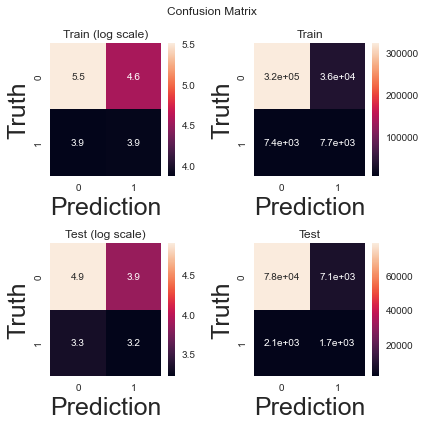

           ROC - Train Data            
           ROC - Test Data            


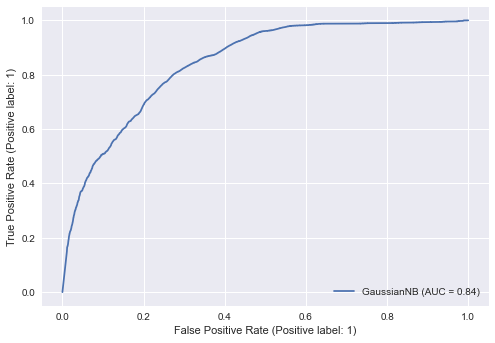

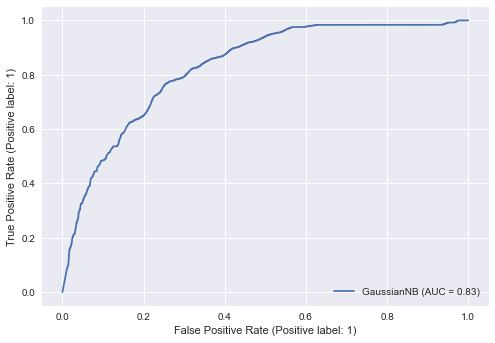

In [32]:
# without smart 999
del model
model = GaussianNB()
model.fit(X_train_log_scaled_tmp.drop("smart_999_raw", axis=1), y_train)
y_train_pred = model.predict(X_train_log_scaled_tmp.drop("smart_999_raw", axis=1))
y_test_pred = model.predict(X_test_log_scaled_tmp.drop("smart_999_raw", axis=1))
evaluate_metrics("gaussian_naive_bayes_log_scaled", y_train, y_train_pred, y_test, y_test_pred, model, X_train_log_scaled_tmp.drop("smart_999_raw", axis=1), X_test_log_scaled_tmp.drop("smart_999_raw", axis=1))

# For train data:
  f2-score  : 37.58266753316258 %
  precision : 17.73313492063492 %
  recall    : 52.18631809435338 %
  accuracy  : 88.30446455577952 %
# For test data:
  f2-score  : 34.948024948024944 %
  precision : 18.75697388975675 %
  recall    : 44.565217391304344 %
  accuracy  : 89.51408080378621 %


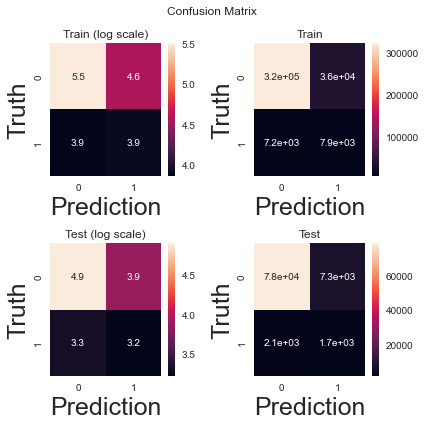

           ROC - Train Data            
           ROC - Test Data            


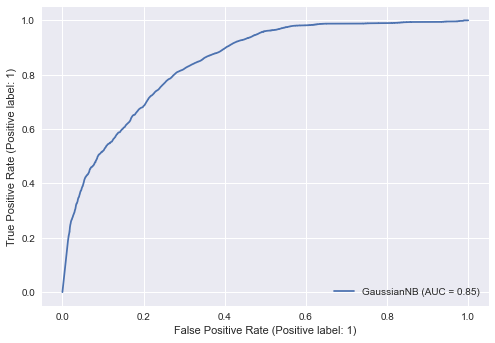

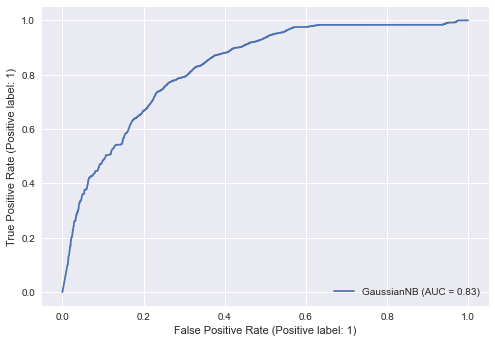

In [33]:
# with smart 999
del model
model = GaussianNB()
model.fit(X_train_log_scaled_tmp, y_train)
y_train_pred = model.predict(X_train_log_scaled_tmp)
y_test_pred = model.predict(X_test_log_scaled_tmp)
evaluate_metrics("gaussian_naive_bayes_log_scaled", y_train, y_train_pred, y_test, y_test_pred, model, X_train_log_scaled_tmp, X_test_log_scaled_tmp)

# Multinomial Naive Bayes (raw data)

# For train data:
  f2-score  : 0.7610966268845238 %
  precision : 6.398910823689585 %
  recall    : 0.6237144184194812 %
  accuracy  : 95.62297403282234 %
# For test data:
  f2-score  : 0.0 %
  precision : 0.0 %
  recall    : 0.0 %
  accuracy  : 95.77967486042269 %


/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/4f/mz1b5sg57p7324fdvfrshs1c0000gn/T/ipykernel_28274/3211062403.py:45: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(confusion_matrix(y_true, y_pred))


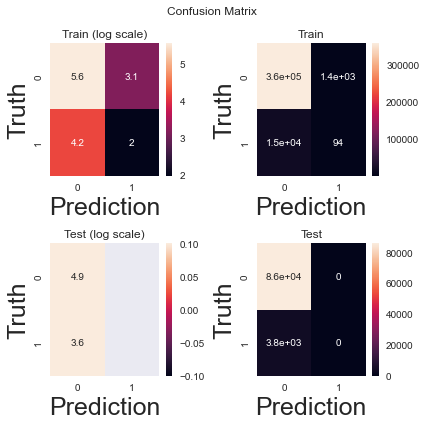

In [34]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train_tmp, y_train)
y_train_pred = model_mnb.predict(X_train_tmp)
y_test_pred = model_mnb.predict(X_test_tmp)
evaluate_metrics("multinomial_naive_bayes_raw", y_train, y_train_pred, y_test, y_test_pred)

# Multinomial Naive Bayes (log and scaled)

# For train data:
  f2-score  : 7.925501894702894 %
  precision : 56.787983824378976 %
  recall    : 6.522460354322872 %
  accuracy  : 96.02876973770499 %
# For test data:
  f2-score  : 2.522312766783081 %
  precision : 20.855614973262032 %
  recall    : 2.067868504772004 %
  accuracy  : 95.53576423464649 %


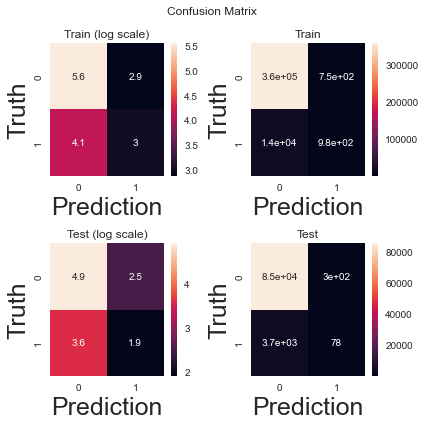

In [35]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train_log_scaled_tmp, y_train)
y_train_pred = model_mnb.predict(X_train_log_scaled_tmp)
y_test_pred = model_mnb.predict(X_test_log_scaled_tmp)
evaluate_metrics("multinomial_naive_bayes_log_scaled", y_train, y_train_pred, y_test, y_test_pred)

# Complement Naive Bayes (log)

# For train data:
  f2-score  : 31.883803845929044 %
  precision : 12.839825820877955 %
  recall    : 50.67347886669763 %
  accuracy  : 84.13328086898099 %
# For test data:
  f2-score  : 31.259661296417164 %
  precision : 12.9786778863296 %
  recall    : 48.25026511134676 %
  accuracy  : 84.16259216576971 %


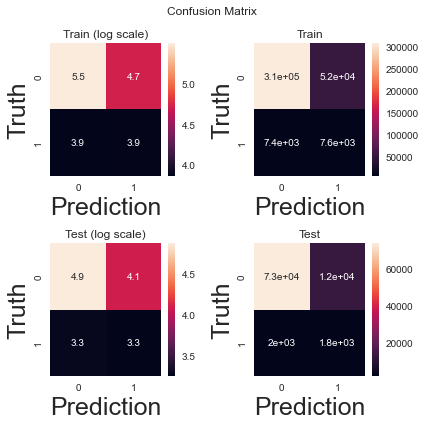

In [36]:
model = ComplementNB()
model.fit(X_train_log_tmp, y_train)
y_train_pred = model.predict(X_train_log_tmp)
y_test_pred = model.predict(X_test_log_tmp)
evaluate_metrics("complement_naive_bayes_log_scaled", y_train, y_train_pred, y_test, y_test_pred)

# Complement Naive Bayes (log and scaled)

# For train data:
  f2-score  : 32.02865122701312 %
  precision : 12.153914855611786 %
  recall    : 54.17689602547939 %
  accuracy  : 82.35457871928091 %
# For test data:
  f2-score  : 32.15674543822913 %
  precision : 12.900860057337155 %
  recall    : 51.29904559915164 %
  accuracy  : 83.32792552893922 %


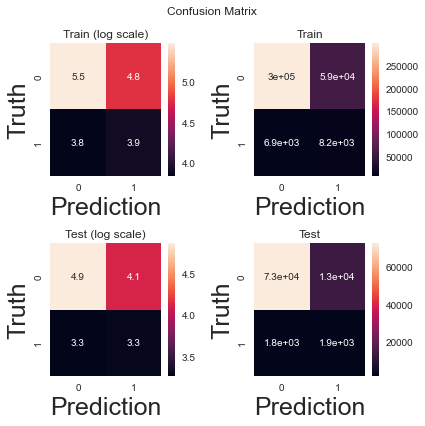

In [37]:
model = ComplementNB()
model.fit(X_train_log_scaled_tmp, y_train)
y_train_pred = model.predict(X_train_log_scaled_tmp)
y_test_pred = model.predict(X_test_log_scaled_tmp)
evaluate_metrics("complement_naive_bayes_log_scaled", y_train, y_train_pred, y_test, y_test_pred)

# Support Vector Machine (log and scaled)

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -10.420340, rho = 1.000143
nSV = 13, nBSV = 10
Total nSV = 13


/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


# For train data:
  f2-score  : 17.368065623192145 %
  precision : 4.034133950057148 %
  recall    : 100.0 %
  accuracy  : 4.034133950057148 %
# For test data:
  f2-score  : 18.053893648590435 %
  precision : 4.220325139577296 %
  recall    : 100.0 %
  accuracy  : 4.220325139577296 %


/var/folders/4f/mz1b5sg57p7324fdvfrshs1c0000gn/T/ipykernel_28274/3211062403.py:45: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(confusion_matrix(y_true, y_pred))
/var/folders/4f/mz1b5sg57p7324fdvfrshs1c0000gn/T/ipykernel_28274/3211062403.py:45: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(confusion_matrix(y_true, y_pred))


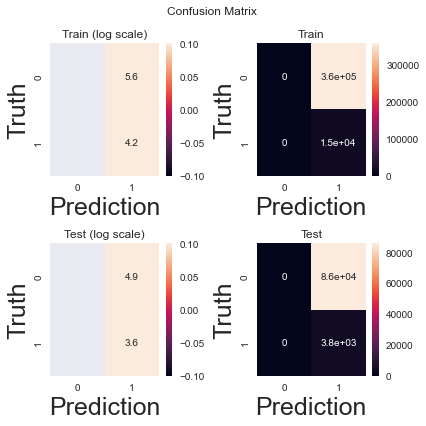

In [38]:
#model = SVC(kernel='rbf', degree=3, gamma='scale', tol=1e-3, class_weight=None, max_iter=-1, random_state=None)
model = SVC(kernel='rbf', degree=3, gamma='scale', tol=1e-3, class_weight='balanced', max_iter=10, random_state=42, verbose=True)
model.fit(X_train_log_scaled_tmp, y_train)
y_train_pred = model.predict(X_train_log_scaled_tmp)
y_test_pred = model.predict(X_test_log_scaled_tmp)
evaluate_metrics("support_vector_machine_log_scaled", y_train, y_train_pred, y_test, y_test_pred)

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1000.683257, rho = 1.288168
nSV = 1097, nBSV = 1000
Total nSV = 1097


/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


# For train data:
  f2-score  : 33.12151094345354 %
  precision : 27.9645166461818 %
  recall    : 34.72231437860792 %
  accuracy  : 93.75834812239184 %
# For test data:
  f2-score  : 25.18191268191268 %
  precision : 23.33815028901734 %
  recall    : 25.689289501590668 %
  accuracy  : 93.3025274958882 %


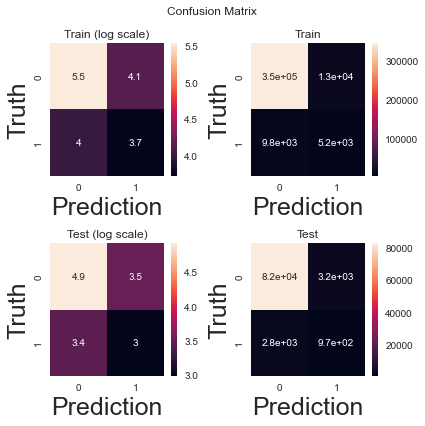

In [39]:
# just another try
model = SVC(kernel='rbf', degree=3, gamma='scale', tol=1e-3, class_weight='balanced', max_iter=1000, random_state=42, verbose=True)
model.fit(X_train_log_scaled_tmp, y_train)
y_train_pred = model.predict(X_train_log_scaled_tmp)
y_test_pred = model.predict(X_test_log_scaled_tmp)
evaluate_metrics("support_vector_machine_log_scaled", y_train, y_train_pred, y_test, y_test_pred)

# More EDA and Feature Engineering

## PCA

[9.62136506e-01 3.75952918e-02 2.68202015e-04 4.53663617e-15
 9.08474428e-17 1.14632686e-17 8.19725658e-18 5.65737184e-19
 4.58409651e-21 1.96975903e-21 6.56419972e-22 9.44067136e-23
 1.76613079e-23 3.31330523e-24 2.48413017e-24 1.71014102e-24
 2.36566531e-25 1.33668373e-47]
[2.68694412e+14 5.31137565e+13 4.48612434e+12 1.84504628e+07
 2.61093850e+06 9.27458579e+05 7.84286163e+05 2.06038154e+05
 1.85467221e+04 1.21575717e+04 7.01828793e+03 2.66159351e+03
 1.15120249e+03 4.98621512e+02 4.31745146e+02 3.58225296e+02
 1.33234574e+02 1.00150845e-09]


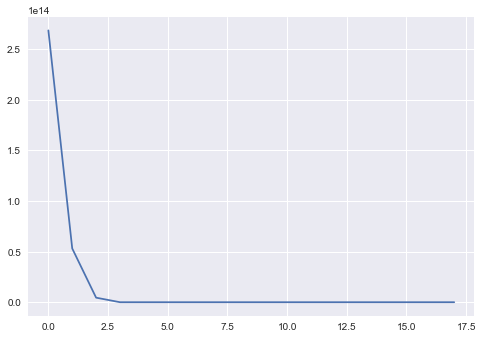

In [40]:
pc = PCA()
pca = pc.fit(X_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
X_pca = pca.transform(X_train)
plt.plot(pca.singular_values_)


<AxesSubplot:xlabel='0', ylabel='1'>

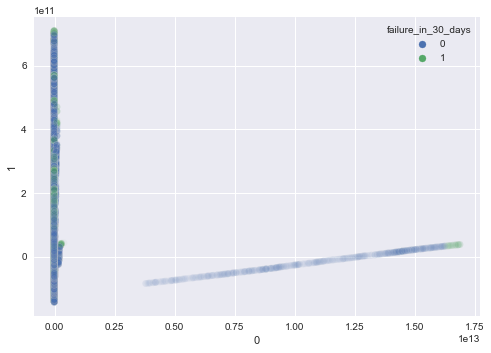

In [41]:
sns.scatterplot(data=pd.concat([pd.DataFrame(X_pca), y_train], axis=1), x=0, y=1, hue="failure_in_30_days", alpha=0.05)

# Time Series

In [42]:
print(df_train.columns)
df_train.head(3)

Index(['date', 'serial_number', 'model', 'failure', 'date_failure',
       'countdown', 'failure_in_30_days', 'smart_4_raw', 'smart_5_raw',
       'smart_7_raw', 'smart_9_raw', 'smart_12_raw', 'smart_183_raw',
       'smart_184_raw', 'smart_187_raw', 'smart_188_raw', 'smart_189_raw',
       'smart_192_raw', 'smart_193_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'smart_999_raw'],
      dtype='object')


,date,serial_number,model,failure,date_failure,countdown,failure_in_30_days,smart_4_raw,smart_5_raw,smart_7_raw,...,smart_188_raw,smart_189_raw,smart_192_raw,smart_193_raw,smart_197_raw,smart_198_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_999_raw
0,2020-09-18,Z304JG86,ST4000DM000,0,2020-11-07,50,0,13.0,0.0,1.208037e+09,...,0.0,0.0,0.0,6846.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,0
1,2020-09-18,S300YQTN,ST4000DM000,0,2021-05-28,252,0,6.0,0.0,1.638586e+09,...,0.0,0.0,0.0,38881.0,16.0,16.0,46671.0,6.363719e+10,2.580255e+11,0
2,2020-09-18,Z302T8AB,ST4000DM000,0,2020-12-04,77,0,27.0,0.0,1.615135e+09,...,0.0,0.0,2.0,12051.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11,0


In [43]:
#serials = ["S300YQTN", "Z302T8AB", "Z304JG86"]
#serials = df_train.sample(3)['serial_number'].unique()
serials = df_train.sample(3, random_state=100)['serial_number'].unique()
print(serials)
df_serials = df_train[df_train["serial_number"].isin(serials)]

['Z304K6DT' 'Z302ALEK' 'S301MJ8S']


<function matplotlib.pyplot.show(close=None, block=None)>

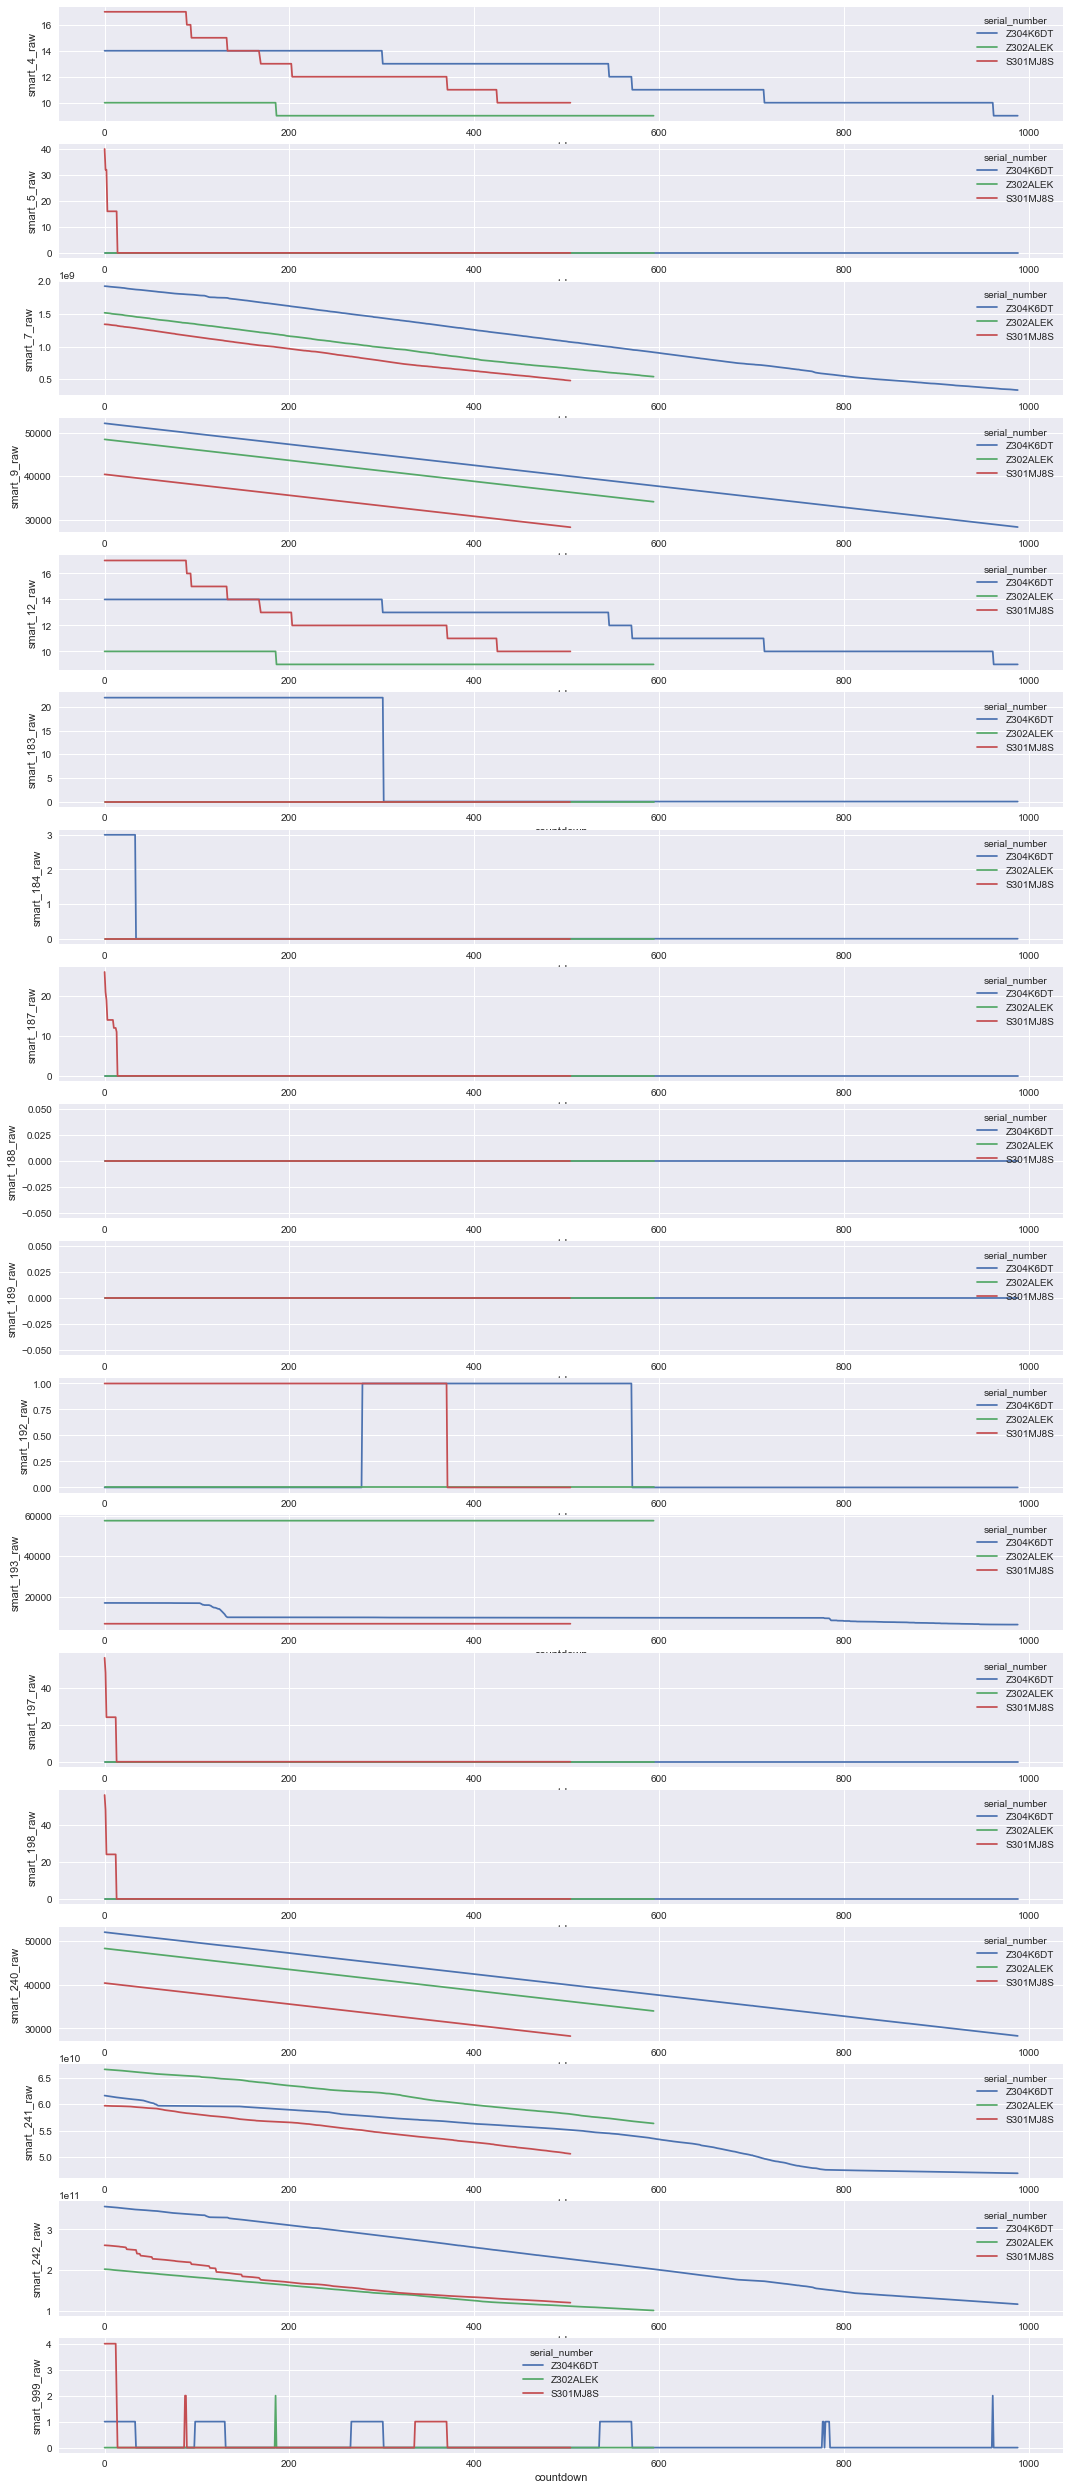

In [44]:
fig, axes = plt.subplots(len(key_smart),1,figsize=(18, 45))
for i, smart_number in enumerate(key_smart):
    #axes[i].set(xlim=(-10, 30))
    sns.lineplot(data=df_serials, x="countdown", y=f'smart_{smart_number}_raw', hue='serial_number', ax=axes[i])
plt.tight_layout
plt.show

#serial = "S300YQTN"
#ax = sns.lineplot(data=df_train.query('serial_number == @serial'), x="countdown", y=f'smart_{smart_number}_raw')

In [45]:

smart2meaningful(None)

Smart 1: read_error_rate
Smart 4: start_stop_count
Smart 5: reallocated_sector_count
Smart 7: seek_error_rate
Smart 9: power_on_time
Smart 12: power_cycle_count
Smart 183: downshift_error_count
Smart 184: end_to_end_error
Smart 187: reported_uncorrectable_error
Smart 188: command_timeout_count
Smart 189: high_fly_write_count
Smart 190: temperature_special
Smart 192: emergency_retract_count
Smart 193: load_cycle_count
Smart 194: temperature
Smart 197: current_pending_sector_count
Smart 198: uncorrectable_sector_count
Smart 199: cable_data_transfer_error
Smart 240: head_flying_time
Smart 241: total_lba_written
Smart 242: total_lba_read


<AxesSubplot:xlabel='countdown', ylabel='smart_999_raw'>

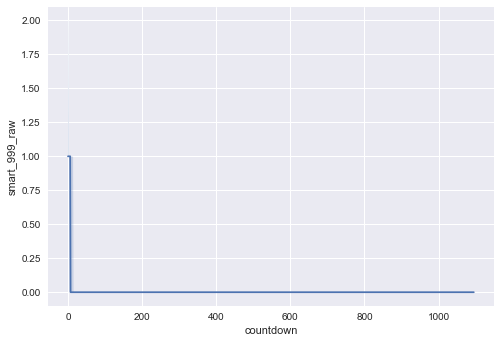

In [46]:
sns.lineplot(data=df_train, x='countdown', y='smart_999_raw', estimator=np.median)

<AxesSubplot:xlabel='smart_999_raw'>

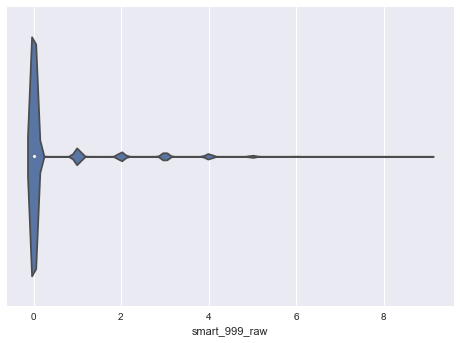

In [47]:
sns.violinplot(data=df_train, x="smart_999_raw")
#sns.violinplot

In [48]:
df_train.query("smart_999_raw == 0")['date'].count()

325063